# Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

Reviews = []
Comments = []

for p in range(1, pages + 1):

    print(f"Scraping page {p}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{p}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content of each page
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    ## Scrape written reviews:
    writtenReviews = parsed_content.find_all("div", {"class":"text_content"})
    for i in range(len(writtenReviews)):
        ## Clean the format of each written review:
        entry = writtenReviews[i].get_text().split("|")
        if len(entry)==2:
            writtenReviews[i] = entry[1].lstrip()
    Comments += writtenReviews
        
    ## Scrape the statistics of each review:
    parsed_stats = parsed_content.find_all("div",{ "class":"review-stats"})
    parsed_stats
    
    headers_values = []
    stars_values = []
    chars_values = []
    for i in range(len(parsed_stats)):

        ## 1) headers for each review:
        headers_names = parsed_stats[i].find_all("td", {"class":"review-rating-header"})
        headers_i = []
        for j in range(len(headers_names)):
            headers_i.append(headers_names[j].get_text())
        headers_values.append(headers_i)

        ## 2) stars-ratings:
        stars_i = parsed_stats[i].find_all("td", {"class":"review-rating-stars"})
        for j in range(len(stars_i)):
            stars_i[j] = int(stars_i[j].find_all("span", {"class":"star fill"})[-1].get_text())
        stars_values.append(stars_i)

        ## 3) values of other characteristics of the flight:
        chars_i = parsed_stats[i].find_all("td", {"class":"review-value"})
        for j in range(len(chars_i)):
            chars_i[j] = chars_i[j].get_text()
        chars_values.append(chars_i)
    
    ## Organize the information of each review in a dictionary, using the header names as keys:
    reviews_all = []
    for i in range(len(parsed_stats)):
        review_i = {}
        reviews_i_values = chars_values[i][:-1] + stars_values[i] + [chars_values[i][-1]]
        for j in range(len(reviews_i_values)):
            review_i[ headers_values[i][j] ] = reviews_i_values[j]
        reviews_all.append(review_i)

    Reviews += reviews_all

    print(f"   ---> {len(reviews_all)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 100 total reviews
Scraping page 3
   ---> 100 total reviews
Scraping page 4
   ---> 100 total reviews
Scraping page 5
   ---> 100 total reviews
Scraping page 6
   ---> 100 total reviews
Scraping page 7
   ---> 100 total reviews
Scraping page 8
   ---> 100 total reviews
Scraping page 9
   ---> 100 total reviews
Scraping page 10
   ---> 100 total reviews


In [5]:
## Convert the collected info into a dataframe:
df = pd.DataFrame(Reviews)
df['Comment'] = Comments
df[:3]

,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft,Comment
0,Couple Leisure,Economy Class,London to Lisbon,September 2024,3.0,2.0,1.0,1.0,1.0,1.0,2,no,NaN,Our flight started in Seattle Wa heading to Li...
1,Solo Leisure,Economy Class,Edinburgh to Delhi via London,September 2024,1.0,1.0,1.0,NaN,1.0,NaN,1,no,NaN,British Airways Flight from Edinburgh got dela...
2,Solo Leisure,Premium Economy,London to Vancouver,September 2024,4.0,5.0,2.0,1.0,3.0,NaN,2,yes,A350,British Airways World Traveller Plus (Premium ...


In [ ]:
## Get dummi indices for 'Recommended':
df_recommend = df['Recommended']

df = pd.concat([df,pd.get_dummies(df['Recommended'], dtype=int)], axis=1)
df.rename(columns={'no':'wont_recommend', 'yes':'will_recommend'}, inplace=True)
df.drop(['Recommended'], axis=1, inplace=True)
df[:3]

In [ ]:
df.to_csv("data/BA_reviews.csv")

# Data overview:

#### Ratings:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type Of Traveller       998 non-null    object 
 1   Seat Type               1000 non-null   object 
 2   Route                   996 non-null    object 
 3   Date Flown              1000 non-null   object 
 4   Seat Comfort            912 non-null    float64
 5   Cabin Staff Service     902 non-null    float64
 6   Food & Beverages        777 non-null    float64
 7   Inflight Entertainment  518 non-null    float64
 8   Ground Service          942 non-null    float64
 9   Wifi & Connectivity     323 non-null    float64
 10  Value For Money         1000 non-null   int64  
 11  Recommended             1000 non-null   object 
 12  Aircraft                529 non-null    object 
 13  Comment                 1000 non-null   object 
dtypes: float64(6), int64(1), object(7)
memory

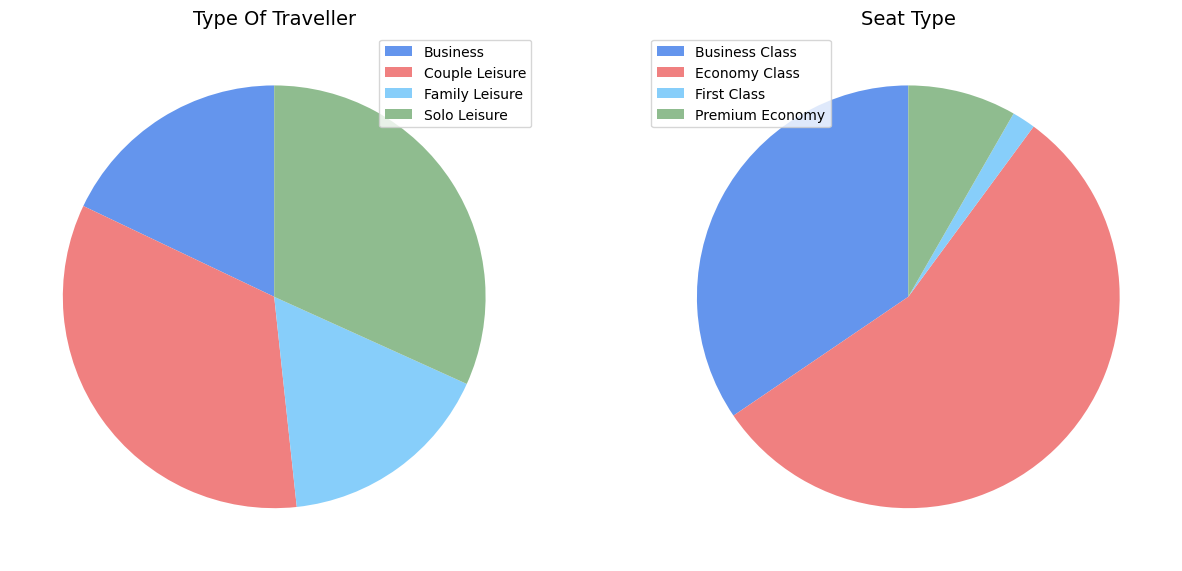

In [13]:
char_features = [ 'Type Of Traveller','Seat Type']

fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,8)

for colm in range(2):
    df_dummies = pd.get_dummies(df[char_features[colm]]).astype(int)

    labels = df_dummies.columns
    colors = ['cornflowerblue', 'lightcoral', 'lightskyblue', 'darkseagreen']
    patches, texts = axs[colm].pie(df_dummies.sum(), colors=colors, startangle=90)
    axs[colm].legend(patches, labels, loc="best")
    axs[colm].set_title(char_features[colm], fontsize=14)

plt.show()

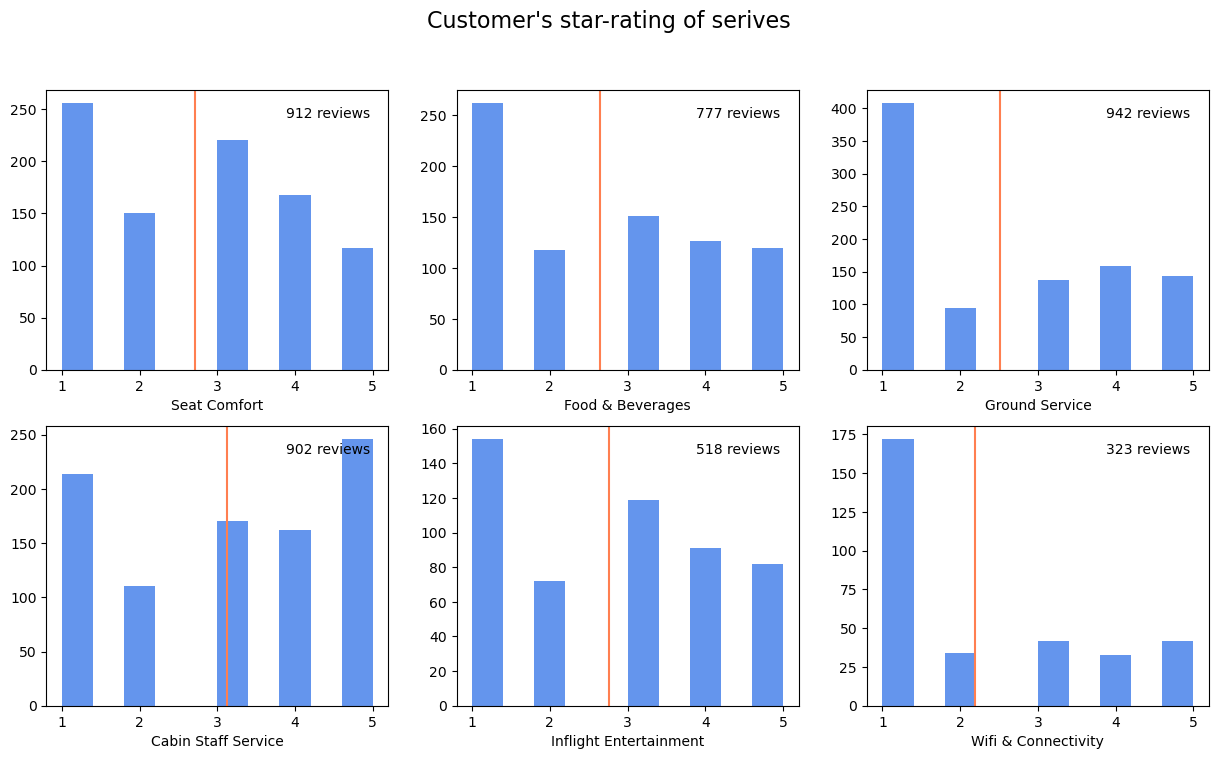

In [9]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        axs[row][colm].hist( df[num_features[i]].dropna(), align='mid', color='cornflowerblue')
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='coral', linestyle='-')
        axs[row][colm].set_xlabel(num_features[i])
        tx = str(int(len(df[num_features[i]].dropna())))+' reviews'
        axs[row][colm].text(0.7,0.9, tx, transform=axs[row][colm].transAxes )
        i += 1
plt.show()

In [ ]:
## Customer's recommendation:
no = df['wont_recommend'].dropna().sum()
yes = df['will_recommend'].dropna().sum()

fig, axs = plt.subplots(1)
labels = ['Customer would recommend','Customer would not recommend']
colors = ['cornflowerblue', 'lightcoral']
patches, texts = axs.pie([yes,no], colors=colors, startangle=90)
axs.legend(patches, labels, loc="upper right")

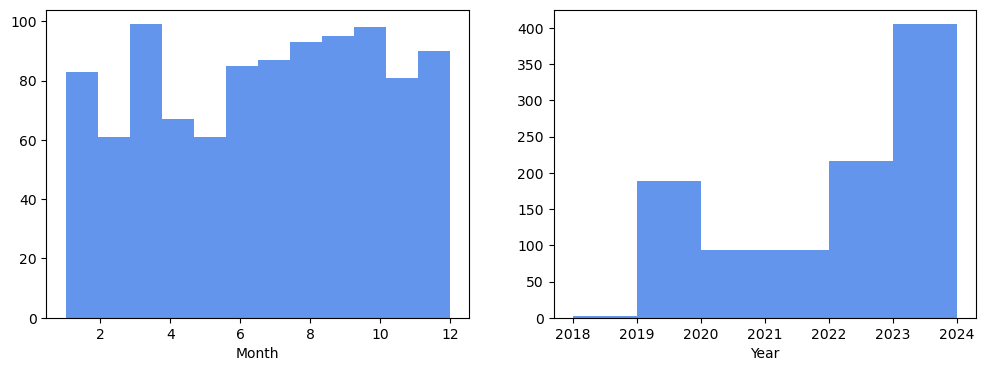

In [15]:
## Define dictionary to convert names of months into numbers:
MonthsHeaders = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthsDic = {}
for i in range(12):
    monthsDic[MonthsHeaders[i]] = i+1

## Collecting all the months and years separately:
months_tracker = []
years_tracker = []
for i in range(len(df['Date Flown'].dropna())):
    month, year = df['Date Flown'][i].split(' ')
    months_tracker.append(monthsDic[month])
    years_tracker.append(int(year))

## Plot histogram:
xlabels = ['Month', 'Year']
xdata = [months_tracker, years_tracker]
binN = [12, max(years_tracker)-min(years_tracker)]
ticksLabels = [MonthsHeaders, np.arange(min(years_tracker), max(years_tracker), 1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,4)
for colm in range(2):
    axs[colm].hist( xdata[colm], align='mid', color='cornflowerblue', bins=binN[colm])
    axs[colm].set_xlabel(xlabels[colm])
    #axs[colm].Axis.set_label_text(ticksLabels[colm])
    
plt.show()

#### Sentiment Analysis:

In [17]:
#!pip install textblob
import textblob

## Obtaining the polarity and subjectivity scores:
## The polarity score is a float within the range [-1.0, 1.0]. 
## The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
pol_list, pol_norm_list  = [], []
sub_list = []
for i in range(len(df)):
    review = textblob.TextBlob(df['Comment'][i])
    pol_list.append(review.sentiment.polarity)
    pol_norm_list.append( (review.sentiment.polarity +1)/2 )
    sub_list.append(review.sentiment.subjectivity)

#df['polarity'] = pol_list
df['normalized_polarity'] = pol_norm_list
df['normalized_subjectivity'] = sub_list

<Figure size 640x480 with 0 Axes>

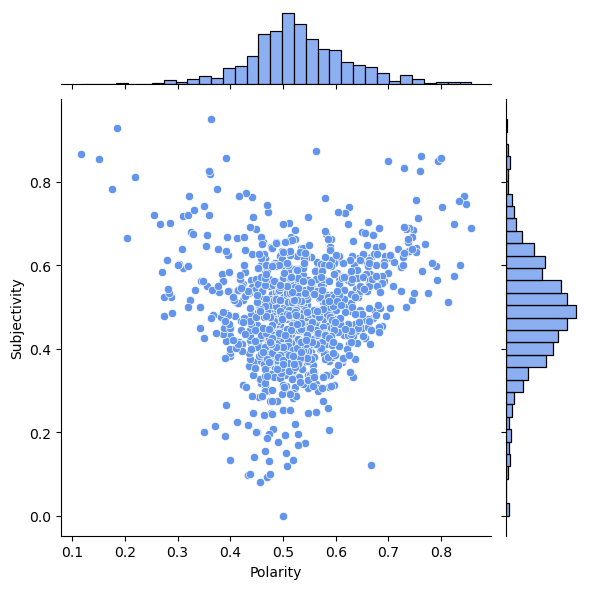

In [21]:
plt.figure()
sns.jointplot(data=df, x='normalized_polarity', y='normalized_subjectivity', color='cornflowerblue')
#sns.histplot(data=df, x='normalized_polarity', y='subjectivity', bins=3, cbar=True)
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
## Other features include identifying-sentences and counting phrases:

#for i in range(1):#len(df)):
#    review = textblob.TextBlob(df['reviews'][i])
#    sentences = review.sentences
#    print(sentences)
#    print(review.noun_phrases.count('insert_phrase'))

#### WordClouds:   

#### SQL queries:

In [ ]:
import csv, sqlite3

## Credentials of the DB2 database:
dsn_hostname = "98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "mzf99447"        # e.g. "abc12345"
dsn_pwd = "7OvJosruh343brjZ"      # e.g. "7dBZ3wWt9XN6$o0J"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "30875"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "SSL"              #i.e. "SSL"
# %sql ibm_db_sa://my-username:my-password@hostname:port/BLUDB?security=SSL

## Connect to the DB2 database:
%load_ext sql
%sql ibm_db_sa://mzf99447:7OvJosruh343brjZ@98538591-7217-4024-b027-8baa776ffad1.c3n41cmd0nqnrk39u98g.databases.appdomain.cloud:30875/BLUDB?security=SSL


Now we create a connection to a database called AIRLINE as well as the cursor object. Then we can create a table also called AIRLINE:

In [ ]:
## Connect to SQLite:
con = sqlite3.connect("AIRLINE.db")
cursor_obj = con.cursor()

In [ ]:
## Create the table:
drop_query = """ drop table AIRLINE;"""
cursor_obj.execute(drop_query)

createQuery = """ CREATE TABLE AIRLINE(
    Type_Of_Traveller VARCHAR(20), 
    Seat_Type VARCHAR(20),
    Route VARCHAR(20),
    Date_Flown VARCHAR(20),
    Seat_Comfort VARCHAR(20),
    Cabin_Staff_Service VARCHAR(20) ,
    Food_and_Beverages VARCHAR(20),
    Ground_Service VARCHAR(20),
    Value_For_Money VARCHAR(20),
    Aircraft VARCHAR(20),
    Inflight_Entertainment VARCHAR(20),
    Wifi_and_Connectivity VARCHAR(20),
    wont_recommend VARCHAR(20) ,
    will_recommend VARCHAR(20) ,
    normalized_polarity FLOAT,
    normalized_subjectivity FLOAT );"""
cursor_obj.execute(createQuery)

con.commit()

In [ ]:
%sql sqlite:///AIRLINE.db
%sql SELECT * FROM AIRLINE LIMIT 5;

To clean the format of the data, we'll:

    .) Replace double-quotation marks within the comments with single-quotation marks, so the database populating with SQL goes smoother.

    .) Replace the missing values with the integer -1. We won't replace them with averages to avoid introducing strong biases into the data, especially in cases where a smaller fraction of the customers gave a star rating.

In [ ]:
for feature in num_features:
    df[feature] = df[feature].replace({np.nan: -1})
    df[feature] = df[feature].astype(int)
df['Comment'] = df['Comment'].replace({'"': "\'"}, regex=True)
df['normalized_polarity'] = round(df['normalized_polarity'],3)
df['normalized_subjectivity'] = round(df['normalized_subjectivity'],3)

We proceed now to fill the table from the panda dataframe:

In [ ]:
## Fill the table:
for i in range(len(df)):
    #review = df['reviews'][i]
    fillQuery = "INSERT INTO AIRLINE VALUES ( "
    fillQuery += '"' + str(df['Type Of Traveller'][i]) + '", '
    fillQuery += '"' + str(df['Seat Type'][i])+ '", '
    fillQuery += '"' + str(df['Route'][i])+ '", '
    fillQuery += '"' + str(df['Date Flown'][i])+ '", '
    fillQuery += str(df['Seat Comfort'][i])+ ', '
    fillQuery += str(df['Cabin Staff Service'][i])+ ', '
    fillQuery += str(df['Food & Beverages'][i])+ ' , '
    fillQuery += str(df['Ground Service'][i])+ ' , '
    fillQuery += str(df['Value For Money'][i])+ ' , '
    fillQuery += '"' + str(df['Aircraft'][i])+ '", '
    fillQuery += str(df['Inflight Entertainment'][i])+ ' , '
    fillQuery += str(df['Wifi & Connectivity'][i])+ ' , '
    #fillQuery += '"' + str(df['Comment'][i])+ '", '
    fillQuery += str(df['wont_recommend'][i])+ ' , '
    fillQuery += str(df['will_recommend'][i])+  ' , '
    fillQuery += str(df['normalized_polarity'][i])+  ' , '
    fillQuery += str(df['normalized_subjectivity'][i])+ ' );'

    #print(i, fillQuery)
    cursor_obj.execute(fillQuery)

con.commit()
cursor_obj.close()

In [ ]:
%sql sqlite:///AIRLINE.db
%sql SELECT * FROM AIRLINE LIMIT 5;

In [ ]:
## If database is locked:
#!fuser REVIEWS.db
#!kill -9 above_output_number

In [ ]:
seat_types = ['Economy Class', 'Premium Economy', 'Business Class', 'First Class']
seat_will_recomm = []
seat_will_recomm_perc = []

cursor_obj = con.cursor()
for i in range(len(seat_types)):
    string_yes = str('SELECT * FROM AIRLINE WHERE will_recommend =1 AND seat_type = "' + seat_types[i] + '";')
    string_yes_value = pd.read_sql(string_yes, con)
    
    string_all = str('SELECT * FROM AIRLINE WHERE seat_type = "' + seat_types[i] + '";')
    string_all_value = pd.read_sql(string_all, con)

    abs = len(string_yes_value)
    per = round(len(string_yes_value)/len(string_all_value)*100,2)
    seat_will_recomm_perc.append(per)
    seat_will_recomm.append(abs)

    print(seat_types[i], per, abs, len(string_all_value))

    if i ==0:
        economy_df = string_all_value
    elif i == 1:    
        premium_economy_df =string_all_value
    elif i==2:
        business_df =string_all_value
    elif i==3:
        first_class_df =string_all_value


cursor_obj.close()

In [ ]:
traveller_types = ['Solo Leisure', 'Couple Leisure', 'Family Leisure', 'Business']
traveller_will_recomm = []
traveller_will_recomm_perc = []

cursor_obj = con.cursor()

for i in range(len(seat_types)):
    string_yes = str('SELECT * FROM AIRLINE WHERE will_recommend =1 AND Type_Of_Traveller = "' + traveller_types[i] + '";')
    string_yes_value = pd.read_sql(string_yes, con)
    
    string_all = str('SELECT * FROM AIRLINE WHERE type_of_traveller = "' + traveller_types[i] + '";')
    string_all_value = pd.read_sql(string_all, con)

    abs =len(string_yes_value)
    per = round(len(string_yes_value)/len(string_all_value)*100,2)
    traveller_will_recomm_perc.append(per)
    traveller_will_recomm.append(abs)
    
    print(traveller_types[i], per, abs, len(string_all_value))

    if i ==0:
        soloT_df = string_all_value
    elif i == 1:    
        coupleT_df =string_all_value
    elif i==2:
        familyT_df =string_all_value
    elif i==3:
        businessT_df =string_all_value
    
cursor_obj.close()

# Data Analysis:

## 1) What has the major influence in customers recommending the airline?

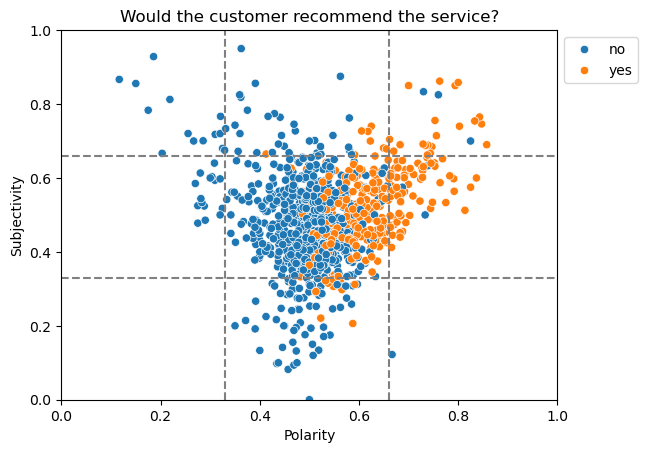

In [23]:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Recommended")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Would the customer recommend the service?")
plt.show()

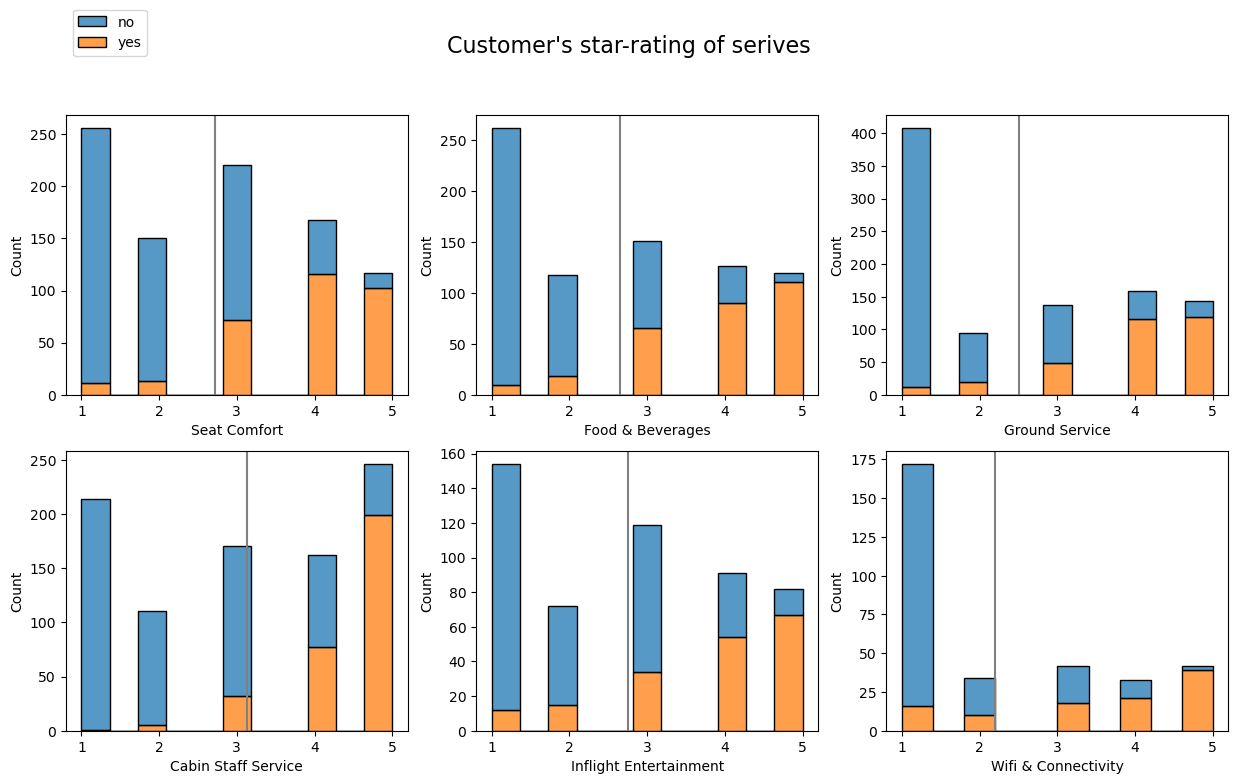

In [25]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Recommended')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Recommended', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        i += 1
plt.show()

## 2) How is the customer's experience affected by their seat type?

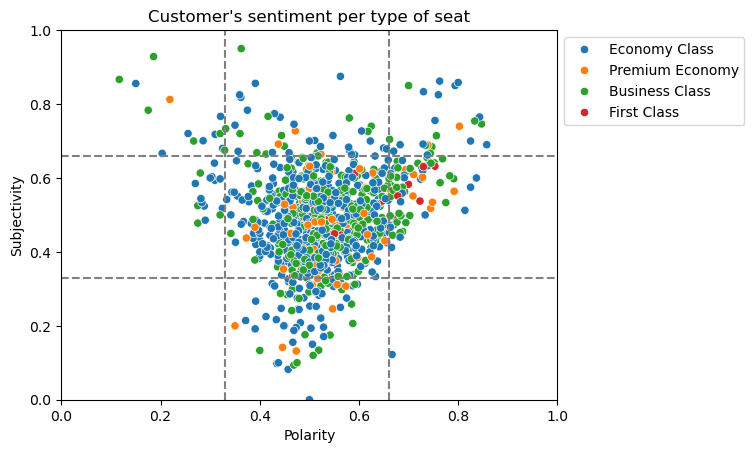

In [27]:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Seat Type")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Customer's sentiment per type of seat")
plt.show()

/tmp/ipykernel_188721/3869036564.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(x=df['Seat Type'], y=df['normalized_polarity'], kind='box', palette='tab10')


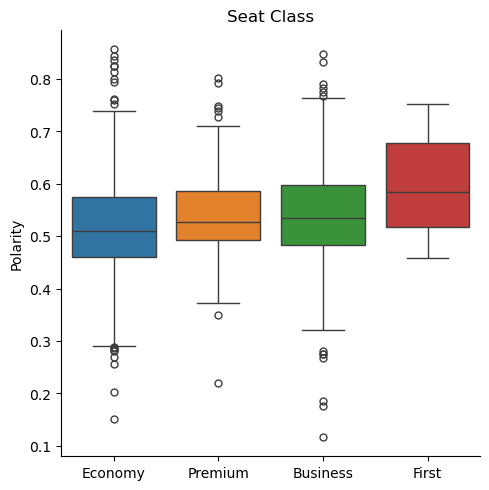

In [29]:
plot = sns.catplot(x=df['Seat Type'], y=df['normalized_polarity'], kind='box', palette='tab10')
plot.set_xticklabels(['Economy', 'Premium', 'Business', 'First']) 
plt.title('Seat Class')
plt.xlabel('')
plt.ylabel('Polarity')
plt.show()

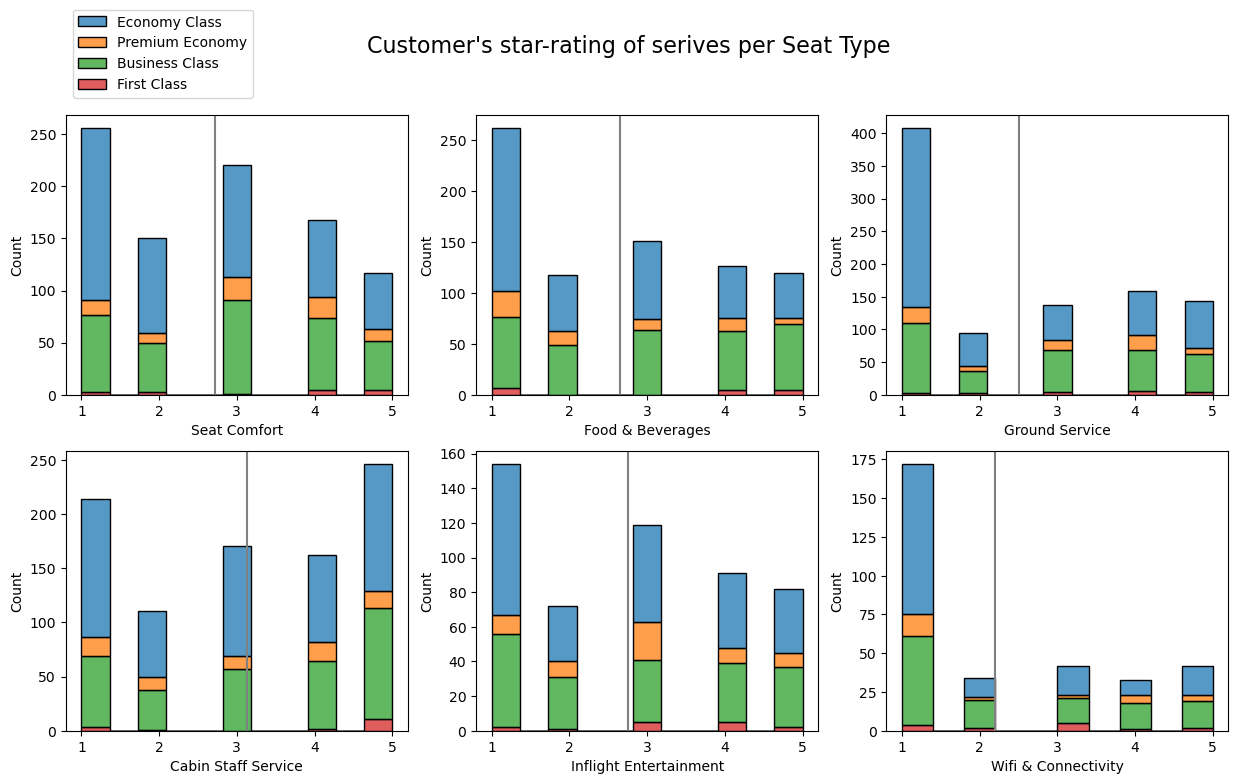

In [31]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives per Seat Type", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i ==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Seat Type')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Seat Type', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        i += 1
plt.show()

Comments:

First Class tent to have a neutral to good experience. 

Economy, Premium and Business have in average a neutral experience with some good exceptions where the customer was really satisfied with the service.

Economy and Business also have exceptions where the customers were really unpleased with the service. 

Economy and Business corresponds to about 90% of the customers. Minimizing the bad experiences in these groups would greatly benefit the airline.

## 3) How is the customer's experience affected by the purpose of their trip?

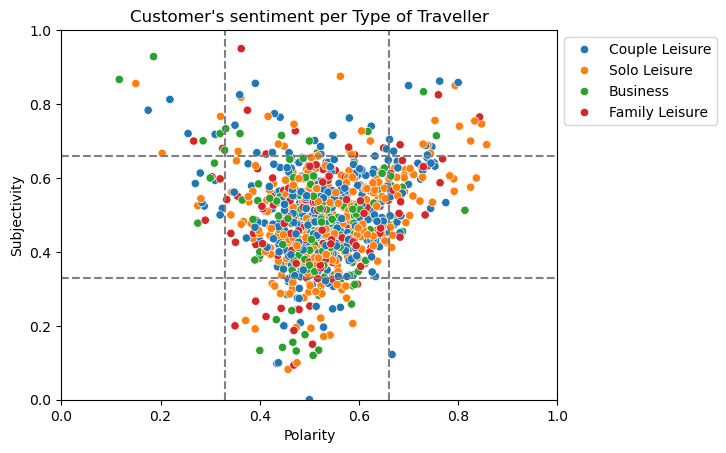

In [33]:
g = sns.scatterplot(data=df, x='normalized_polarity', y='normalized_subjectivity', hue="Type Of Traveller")
sns.move_legend(g, "upper left", title='', frameon=True, bbox_to_anchor=(1, 1))
g.axvline(x=0.33, color='gray', linestyle='--')
g.axvline(x=0.66, color='gray', linestyle='--')
g.axhline(y=0.33, color='gray', linestyle='--')
g.axhline(y=0.66, color='gray', linestyle='--')
g.set_xlim(0, 1)
g.set_ylim(0,1)
g.set_xlabel('Polarity')
g.set_ylabel('Subjectivity')
g.set_title("Customer's sentiment per Type of Traveller")
plt.show()

/tmp/ipykernel_188721/3199379262.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.catplot(x=df['Type Of Traveller'], y=df['normalized_polarity'], kind='box', palette='tab10')


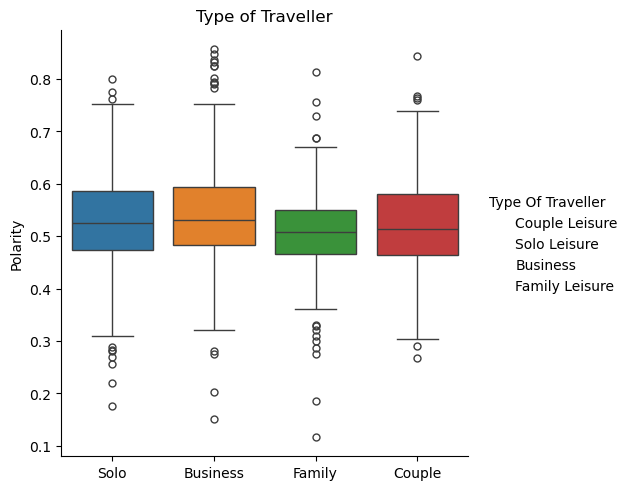

In [35]:
plot = sns.catplot(x=df['Type Of Traveller'], y=df['normalized_polarity'], kind='box', palette='tab10')
plot.set_xticklabels(['Solo', 'Business', 'Family', 'Couple']) 
plt.title('Type of Traveller')
plt.xlabel('')
plt.ylabel('Polarity')
plt.show()

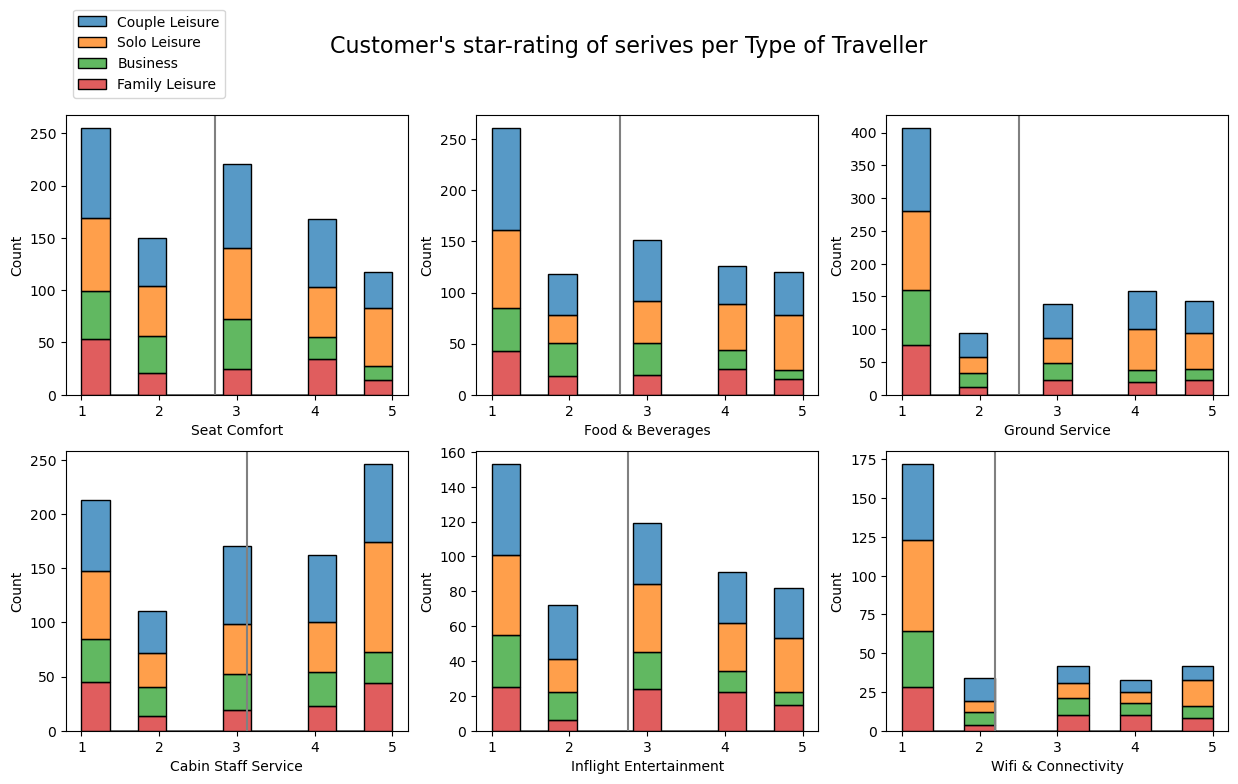

In [37]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,8)
fig.suptitle("Customer's star-rating of serives per Type of Traveller", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Type Of Traveller')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.histplot(ax=axs[row][colm], data=df, x=df[num_features[i]].dropna(), multiple='stack', hue='Type Of Traveller', legend=False)
        axs[row][colm].axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        i += 1
plt.show()

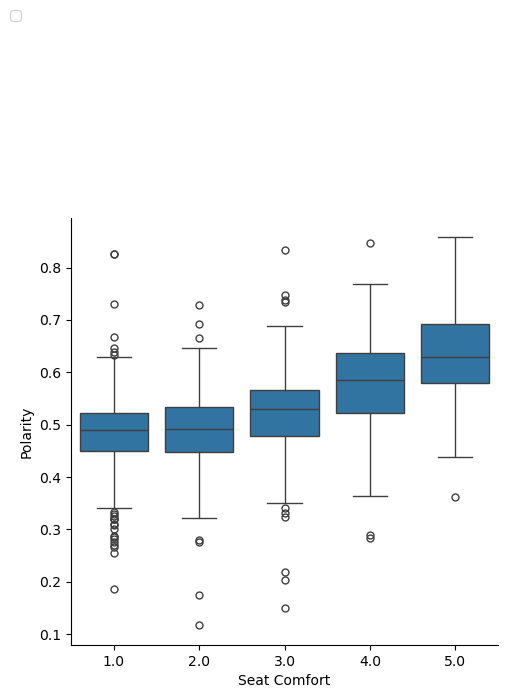

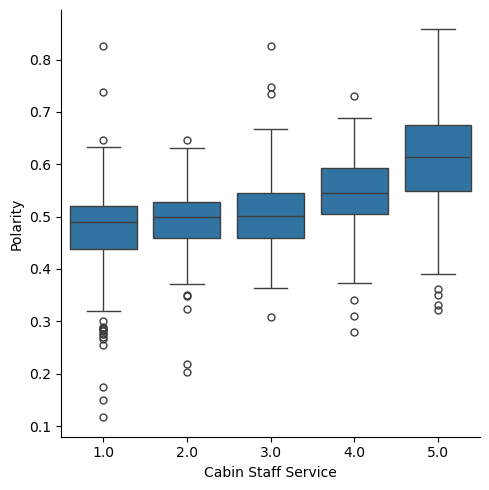

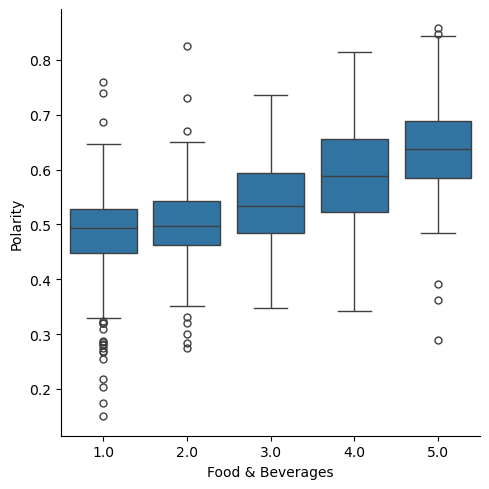

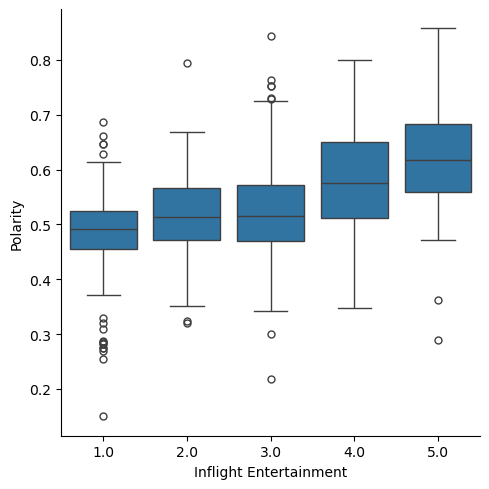

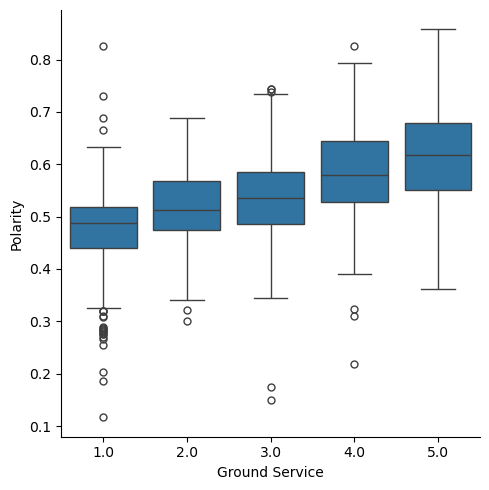

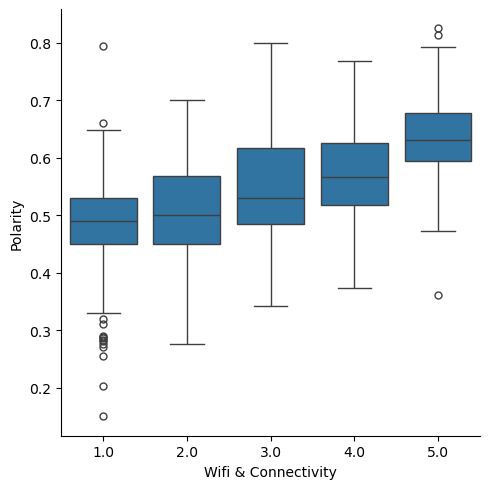

In [47]:
num_features = ['Seat Comfort','Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity' ]

fig.suptitle("Customer's star-rating of serives per Type of Traveller", fontsize=16)
i=0
for colm in range(3):
    for row in range(2):
        if i==0:
            pl = sns.catplot(data=df, x=df[num_features[i]].dropna(), y=df['normalized_polarity'], kind='box')
            sns.move_legend(pl, "upper left", title='', frameon=True, bbox_to_anchor=(0, 1.4))
        else:
            pl = sns.catplot(data=df, x=df[num_features[i]].dropna(), y=df['normalized_polarity'], kind='box',legend=False)
        #plt.axvline(x=df[num_features[i]].mean(), color='gray', linestyle='-')
        plt.ylabel('Polarity')
        i += 1
plt.show()